# Projet Science des données: Prédiction de sinistres automobiles

Ce notebook implémente les étapes d'un projet de classification supervisée selon les consignes de `projet_2023.pdf`:
- Importation des données
- Exploration et examen des données
- Préparation et prétraitement
- Analyse des corrélations
- Séparation jeux d'apprentissage et test
- Entraînement de modèles (régression logistique)
- Évaluation et validation croisée
- Comparaison de plusieurs classifieurs
- Sauvegarde du meilleur modèle

# 0. Important des librairies

In [340]:
import pandas as pd
import duckdb as db
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


# 1. Importation des données

In [316]:
df = pd.read_csv('data/car_insurance.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10000 non-null  int64  
 1   age                  10000 non-null  int64  
 2   gender               10000 non-null  int64  
 3   driving_experience   10000 non-null  object 
 4   education            10000 non-null  object 
 5   income               10000 non-null  object 
 6   credit_score         9018 non-null   float64
 7   vehicle_ownership    10000 non-null  float64
 8   vehicle_year         10000 non-null  object 
 9   married              10000 non-null  float64
 10  children             10000 non-null  float64
 11  postal_code          10000 non-null  int64  
 12  annual_mileage       9043 non-null   float64
 13  vehicle_type         10000 non-null  object 
 14  speeding_violations  10000 non-null  int64  
 15  duis                 10000 non-null  

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,3,0,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,0,1,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,0,0,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,0,1,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,1,1,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


# 2. Examen des données

In [317]:
print(f"Nombre de lignes : {df.shape[0]} et nombre de colonnes : {df.shape[1]}")

Nombre de lignes : 10000 et nombre de colonnes : 18


## Valeurs Manquantes

In [318]:
for column in df.columns:
    print(f'{column} : {df[column].isnull().sum()}')

id : 0
age : 0
gender : 0
driving_experience : 0
education : 0
income : 0
credit_score : 982
vehicle_ownership : 0
vehicle_year : 0
married : 0
children : 0
postal_code : 0
annual_mileage : 957
vehicle_type : 0
speeding_violations : 0
duis : 0
past_accidents : 0
outcome : 0


## Valeurs prise par colonnes

In [319]:
for column in df.columns.tolist():
    print(column)
    print(df[column].value_counts())
    print("---------------------------------")

id
id
569520    1
702473    1
426507    1
386239    1
454670    1
         ..
931908    1
672440    1
297005    1
559584    1
442696    1
Name: count, Length: 10000, dtype: int64
---------------------------------
age
age
1    3063
2    2931
0    2016
3    1990
Name: count, dtype: int64
---------------------------------
gender
gender
0    5010
1    4990
Name: count, dtype: int64
---------------------------------
driving_experience
driving_experience
0-9y      3530
10-19y    3299
20-29y    2119
30y+      1052
Name: count, dtype: int64
---------------------------------
education
education
high school    4157
university     3928
none           1915
Name: count, dtype: int64
---------------------------------
income
income
upper class      4336
middle class     2138
poverty          1814
working class    1712
Name: count, dtype: int64
---------------------------------
credit_score
credit_score
0.629027    1
0.618094    1
0.396540    1
0.578306    1
0.633275    1
           ..
0.309272    1
0

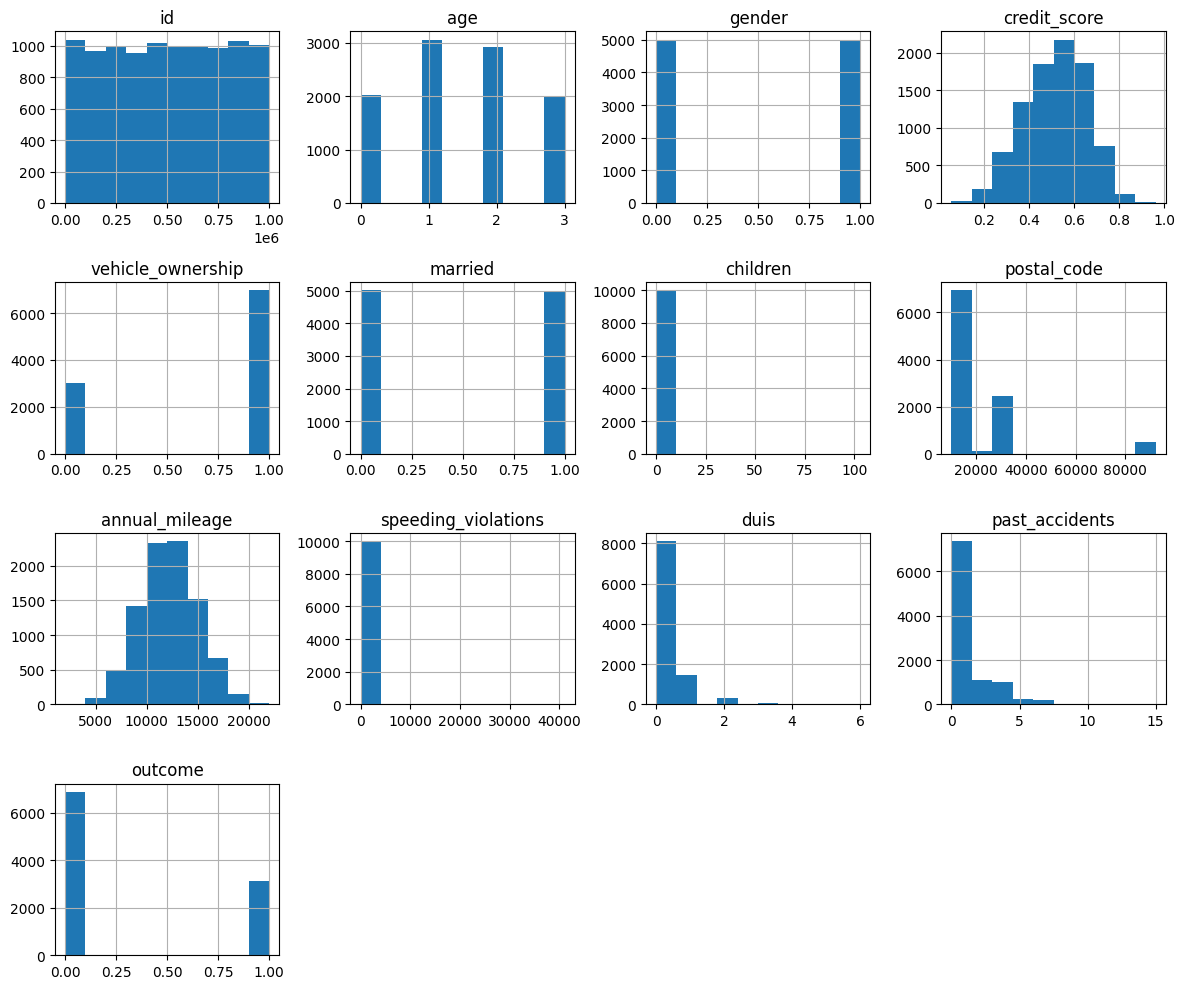

In [320]:
df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

# 3.Préparation des données

## Suppression des colonnes inutiles

In [321]:
# Suppression de la colonne 'id', aléatoire et sans utilité pour l'apprentissage du modèle
df.drop('id', axis=1, inplace=True)

## Données aberrantes

#### Children

In [322]:
# Valeurs disponibles de children
df['children'].value_counts()
db.sql("SELECT * FROM df WHERE children > 10").df()

,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,0,0,0-9y,none,poverty,0.186185,0.0,before 2015,0.0,103.0,10238,17000.0,sedan,0,0,0,1.0
1,1,0,0-9y,none,poverty,0.207650,0.0,before 2015,1.0,24.0,10238,11000.0,sedan,0,0,0,1.0
2,0,1,0-9y,none,poverty,0.209536,0.0,before 2015,1.0,72.0,32765,14000.0,sedan,0,0,0,1.0


In [323]:
# Rectification des données aberrantes (plus de 10 enfants) de la colonne children par la mediane
df.loc[df['children'] > 10, 'children'] = df.loc[df['children'] <= 10, 'children'].median()

#### Speeding Violations

In [324]:
# Rectification des données aberrantes comptabilisant plus de 1000 excès de vitesse dans la colonne speeding_violations par la médiane.
df.loc[df['speeding_violations'] > 100, 'speeding_violations'] = df.loc[df['speeding_violations'] < 100, 'speeding_violations'].median()

In [325]:
df.head()

,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,3,0,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,0,1,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,0,0,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,0,1,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,1,1,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


## Données manquantes

In [326]:
for column in df.columns.tolist():
    if df[column].isna().mean() > 0.3:
        # Supprime la colonne si elle contient plus de 30% de données N/A
        df.drop([column], axis=1, inplace=True)
    elif df[column].dtype == 'int64':
        # Remplace les N/A par la médiane
        df[column] = df[column].fillna(df[column].median())
    elif df[column].dtype == 'float64':
        # Remplace les N/A par la moyenne
        df[column] = df[column].fillna(df[column].mean())
    elif df[column].dtype == 'object':
        # Remplace les N/A par la valeur la plus fréquente
        most_frequent_value = df[column].mode(dropna=True)[0]
        df[column] = df[column].fillna(most_frequent_value)


## Transformation des variables qualitatives en variables numeriques :

In [327]:
encoders, mappings = {}, {}
for col in df.select_dtypes('object'):
    le = LabelEncoder().fit(df[col].astype(str))
    df[col] = le.transform(df[col].astype(str))
    encoders[col] = le
    mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

## Normalisation des données

In [328]:
target = 'outcome'
features = df.columns.tolist()
features.remove(target)
scaler = StandardScaler().set_output(transform="pandas")
df[features] = scaler.fit_transform(df[features])


# 4.Recherche de corrélation

Corrélation avec 'outcome' :
 outcome                1.000000
vehicle_year           0.294178
annual_mileage         0.177575
gender                 0.107208
postal_code            0.095889
vehicle_type           0.005620
income                -0.047560
education             -0.092643
duis                  -0.189352
children              -0.232237
married               -0.261807
speeding_violations   -0.291862
credit_score          -0.309010
past_accidents        -0.311495
vehicle_ownership     -0.378921
age                   -0.448463
driving_experience    -0.497431
Name: outcome, dtype: float64


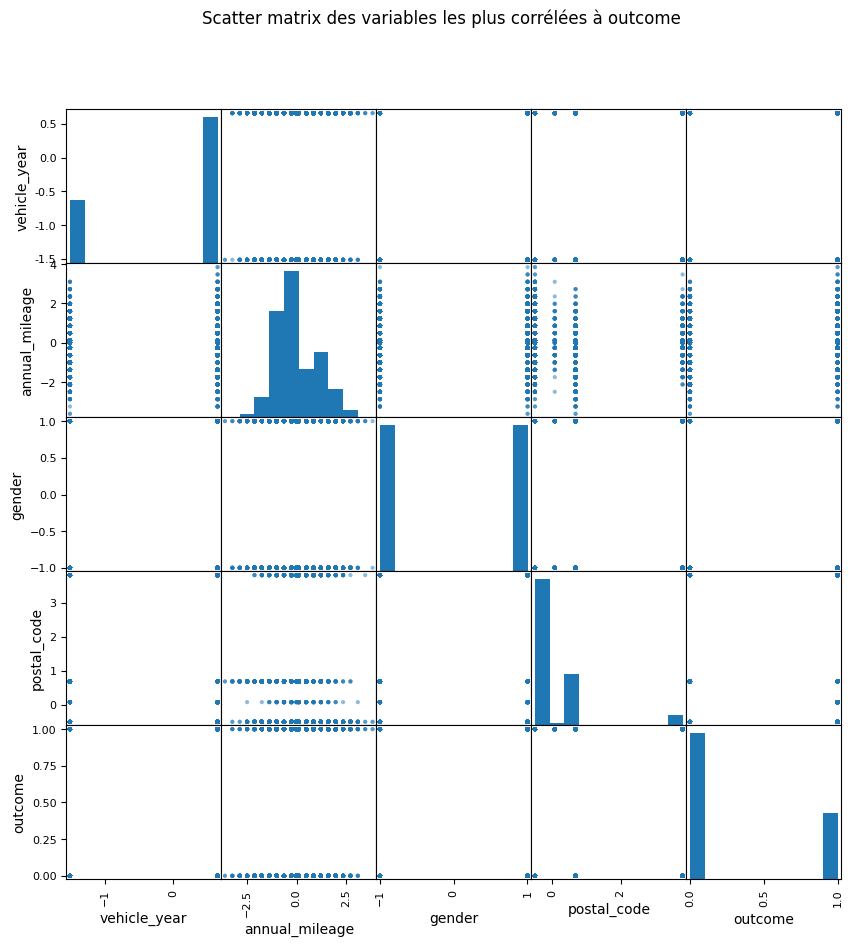

In [329]:
df_corr = df.copy()
corr_matrix = df_corr.corr()
corr_with_target = corr_matrix['outcome'].sort_values(ascending=False)
print("Corrélation avec 'outcome' :\n", corr_with_target)

top_features = corr_with_target.index[1:5].tolist()

scatter_matrix(df_corr[top_features + ['outcome']], figsize=(10, 10))
plt.suptitle("Scatter matrix des variables les plus corrélées à outcome")
plt.show()

# 5.Extraction des jeux d’apprentissage et de test

In [330]:
# Séparation des variables explicatives (X) et de la variable cible (y)
X = df.drop(columns='outcome').values
y = df['outcome'].values

# Division en jeux d'entraînement (75%) et de test (25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

total = len(df)
print(f"Taille totale : {total} exemples")
print(f"Jeu d'entraînement : {len(X_train)} exemples ({len(X_train)/total:.2%})")
print(f"Jeu de test : {len(X_test)} exemples ({len(X_test)/total:.2%})")

Taille totale : 10000 exemples
Jeu d'entraînement : 7500 exemples (75.00%)
Jeu de test : 2500 exemples (25.00%)


# 6.Entraînement d'un modèle

In [335]:
model = LogisticRegression(
    C =1,
    max_iter=1000,
    random_state=42
)
model.fit(X, y)

/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = 

LogisticRegression(C=1, max_iter=1000, random_state=42)

# 7.Evaluation du modèle

In [332]:
y_predict_test = model.predict(X_test)

/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [333]:
for i in range(len(X_test)):
    print(f'{y_test[i]} : {y_predict_test[i]} ')

1.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
1.0 : 1.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
1.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 0.0 
1.0 : 1.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
1.0 : 1.0 
1.0 : 1.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 0.0 
0.0 : 1.0 
1.0 : 1.0 
1.0 : 0.0 
1.0 : 1.0 
0.0 : 0.0 
1.0 : 1.0 
0.0 : 1.0 
1.0 : 0.0 
0.0 : 0.0 
0.0 : 1.0 
0.0 : 0.0 
1.0 : 1.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
0.0 : 0.0 
1.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
1.0 : 1.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
1.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
0.0 : 0.0 
1.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
1.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
1.0 : 1.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 
1.0 : 1.0 
0.0 : 1.0 
0.0 : 0.0 
0.0 : 0.0 
0.0 : 0.0 

In [341]:
def classification_metrics(y_true, y_pred):
    return {
        'accuracy':         accuracy_score(y_true, y_pred),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'precision':        precision_score(y_true, y_pred),
        'recall':           recall_score(y_true, y_pred),
        'f1_score':         f1_score(y_true, y_pred),
    }

y_pred = model.predict(X_test)
metrics = classification_metrics(y_test, y_pred)

print(f"Accuracy {metrics['accuracy']:.4f}")
print("Matrice de confusion :")
print(metrics['confusion_matrix'])
print(f"Precision : {metrics['precision']:.4f}")
print(f"Recall : {metrics['recall']:.4f}")
print(f"F1 Score : {metrics['f1_score']:.4f}")

Accuracy 0.8436
Matrice de confusion :
[[1555  168]
 [ 223  554]]
Precision : 0.7673
Recall : 0.7130
F1 Score : 0.7392


/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


# 8.Amélioration de l’évaluation

In [343]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

def cross_val_classification_metrics(model, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    return {
        'accuracy':cross_val_score(model, X, y, cv=kf, scoring='accuracy'),
        'precision':cross_val_score(model, X, y, cv=kf, scoring='precision'),
        'recall':cross_val_score(model, X, y, cv=kf, scoring='recall'),
        'f1_score':cross_val_score(model, X, y, cv=kf, scoring='f1'),
    }

metrics = cross_val_classification_metrics(model, X, y)

print("Évaluation en validation croisée sur 5 folds :")
for metric_name, scores in metrics.items():
    print(f"{metric_name.capitalize():<10} : Moyenne = {np.mean(scores):.4f} | Écart-type = {np.std(scores):.4f}")

Évaluation en validation croisée sur 5 folds :
Accuracy   : Moyenne = 0.8437 | Écart-type = 0.0064
Precision  : Moyenne = 0.7657 | Écart-type = 0.0151
Recall     : Moyenne = 0.7224 | Écart-type = 0.0202
F1_score   : Moyenne = 0.7432 | Écart-type = 0.0125


/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = 